In [1]:
import sys
import math
import numpy as np
import scipy
import matplotlib.pyplot as plt

sys.path.append('..')
from src.kernels import exp_kernel, complex_exp_kernel, complex_discrete_kernel
from src.probability import Distribution
from src.spectral_transforms import psi_real_to_circle, psi_inv_circle_to_real, B_real, B_circle
from src.numerical import trap_quad, fourier_quad, conv_trap, conv_fourier, volterra_cm_numerical_inversion, volterra_pd_numerical_inversion
from src.plotting import plot_real_distribution, plot_discrete

plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=8)
plt.rcParams.update({
    'font.size': 8,
    'text.usetex': True,
    'text.latex.preamble': r"\usepackage{amsfonts}" + "\n" + r"\usepackage{amsmath}" + "\n" + r"\usepackage{amssymb}"
})

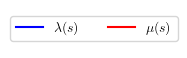

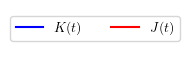

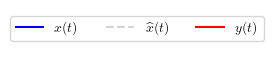

In [47]:
fig, ax = plt.subplots(figsize=(2, 0.5))

# Create empty lines with labels
ax.plot([], [], color="blue")
ax.plot([], [], color="red")
ax.axis('off')

# Create the legend
plt.legend(["$\lambda(s)$", "$\mu(s)$"], bbox_to_anchor=[0.5, 0.5], loc='center', fontsize=10, ncol=4)

plt.savefig('../figures/main_invert_distribution_legend.pdf', bbox_inches='tight', pad_inches=0.1)



fig, ax = plt.subplots(figsize=(2, 0.5))

# Create empty lines with labels
ax.plot([], [], color="blue")
ax.plot([], [], color="red")
ax.axis('off')

# Create the legend
plt.legend(["$K(t)$", "$J(t)$"], bbox_to_anchor=[0.5, 0.5], loc='center', fontsize=10, ncol=4)

plt.savefig('../figures/main_invert_kernel_legend.pdf', bbox_inches='tight', pad_inches=0.1)


fig, ax = plt.subplots(figsize=(2, 0.5))

# Create empty lines with labels
ax.plot([], [], color="blue")
ax.plot([], [], color="lightgray", linestyle="--")
ax.plot([], [], color="red")
ax.axis('off')

# Create the legend
plt.legend(["$x(t)$", "$\widehat{x}(t)$", "$y(t)$"], bbox_to_anchor=[0.5, 0.5], loc='center', fontsize=10, ncol=4)

plt.savefig('../figures/main_invert_data_legend.pdf', bbox_inches='tight', pad_inches=0.1)

/var/folders/pw/wkdn0vxs0b54swhpwjg6s0x00000gn/T/ipykernel_38041/232237164.py:38: RuntimeWarning: divide by zero encountered in divide
  mu_density = lambda s: (s > 0) * (s < 1) / (1 + (s + np.log(np.abs(1-1/s)))**2/np.pi**2)
/var/folders/pw/wkdn0vxs0b54swhpwjg6s0x00000gn/T/ipykernel_38041/232237164.py:38: RuntimeWarning: divide by zero encountered in log
  mu_density = lambda s: (s > 0) * (s < 1) / (1 + (s + np.log(np.abs(1-1/s)))**2/np.pi**2)


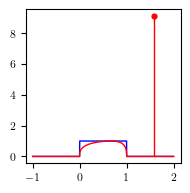

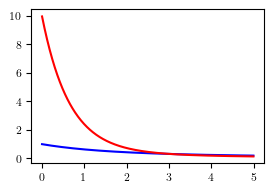

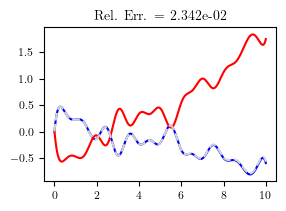

In [9]:
# Define analytical spectral distribution lambda
density = lambda s: (s > 0) * (s < 1)
atoms = np.array([])
atom_wts = np.array([])
quad_pts, quad_wts = trap_quad(-1, 2, int(1e4))
lmbda = Distribution(density, atoms, atom_wts, quad_pts, quad_wts)

# Define noisy input trajectory x(t)
T = 10
t = np.linspace(0, T, 1000)
dt = t[1] - t[0]

n_interp = 20
np.random.seed(1)
interp_xs = np.cumsum(np.insert(np.random.randn(n_interp), 0, 0))/np.sqrt(n_interp)
interp_ts = np.linspace(0, T, n_interp+1)
cs = scipy.interpolate.make_interp_spline(interp_ts, interp_xs, k=5)
x = cs(t)

# Define Volterra equation kernel and coefficients
K = exp_kernel(lmbda, t)
c0 = 1
c1 = 0

# Compute output trajectory y(t) and corrupt it with noise
xdot = np.gradient(x, dt)
y = c1*xdot - c0*x - conv_trap(K, x, t)
ydot = np.gradient(y, dt)

# Use the spectral inversion map B to compute the inverse spectra mu and mu_hat from lambda and lambda_hat
#mu, zeta0, zeta1 = B_real(lmbda, c0, c1)

# Compute the analytical inverse kernel J corresponding to K, and use it to reconstruct x
#J_spectral = exp_kernel(mu, t)

alpha1 = 1/(1-np.exp(-1))
beta1 = np.pi**2/(np.exp(1) + np.exp(-1) - 2)
mu_density = lambda s: (s > 0) * (s < 1) / (1 + (s + np.log(np.abs(1-1/s)))**2/np.pi**2)
mu_analytic = Distribution(mu_density, np.array([alpha1]), np.array([beta1]), quad_pts, quad_wts)
J_analytic = exp_kernel(mu_analytic, t)

zeta0 = -np.pi**2
zeta1 = 0
x_analytic = (-1/math.pi**2) * (zeta1*ydot - zeta0*y - conv_trap(J_analytic, y, t))

#rel_err_J = np.linalg.norm(J_spectral - J_analytic) / np.linalg.norm(J_analytic)
rel_err_x = np.linalg.norm(x_analytic - x) / np.linalg.norm(x)

fig, ax = plt.subplots(figsize=(2, 2))
plot_real_distribution(ax, lmbda, color="blue")
plot_real_distribution(ax, mu_analytic, color="red")
plt.savefig(f"../figures/main_cm_distribution_inversion.pdf", bbox_inches='tight', pad_inches=0.08)
plt.show()

fig, ax = plt.subplots(figsize=(3, 2))
ax.plot(t[t < 5], K[t < 5], color="blue")
ax.plot(t[t < 5], J_analytic[t < 5], color="red")
plt.savefig(f"../figures/main_cm_kernel_inversion.pdf", bbox_inches='tight', pad_inches=0.08)
plt.show()

fig, ax = plt.subplots(figsize=(3, 2))
ax.plot(t, x, color="blue", zorder=1)
ax.plot(t, y, color="red")
ax.plot(t, x_analytic, linestyle='--', color="lightgray")
ax.set_title(f"Rel. Err. = {rel_err_x:.3e}", size=10)
plt.savefig(f"../figures/main_cm_data_inversion.pdf", bbox_inches='tight', pad_inches=0.08)
plt.show()

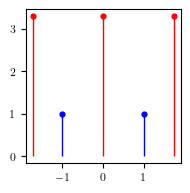

/Users/georgestepaniants/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/georgestepaniants/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


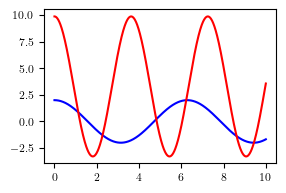

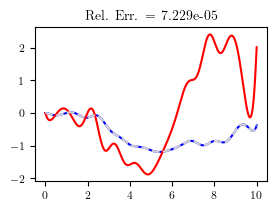

In [ ]:
# Define analytical spectral distribution lambda
density = None
atoms = np.array([-1, 1])
atom_wts = np.array([1, 1])
quad_pts, quad_wts = trap_quad(-2, 2, int(1e3))
lmbda = Distribution(density, atoms, atom_wts, quad_pts, quad_wts)

# Define noisy input trajectory x(t)
T = 10
t = np.linspace(0, T, 1000)
dt = t[1] - t[0]

n_interp = 20
np.random.seed(15)
interp_xs = np.cumsum(np.insert(np.random.randn(n_interp), 0, 0))/np.sqrt(n_interp)
interp_ts = np.linspace(0, T, n_interp+1)
cs = scipy.interpolate.make_interp_spline(interp_ts, interp_xs, k=5)
x = cs(t)

# Define Volterra equation kernel and coefficients
K = complex_exp_kernel(lmbda, t)
c0 = 0
c1 = 1

# Compute output trajectory y(t) and corrupt it with noise
xdot = np.gradient(x, dt)
y = c1*xdot - 1j*c0*x + conv_trap(K, x, t)
ydot = np.gradient(y, dt)

# Use the spectral inversion map B to compute the inverse spectra mu and mu_hat from lambda and lambda_hat
#mu, zeta0, zeta1 = B_real(lmbda, c0, c1)

# Compute the analytical inverse kernel J corresponding to K, and use it to reconstruct x
#J_spectral = exp_kernel(mu, t)

alpha1 = -np.sqrt(3)
alpha2 = 0
alpha3 = np.sqrt(3)
beta1 = np.pi**2/3
beta2 = np.pi**2/3
beta3 = np.pi**2/3
mu_density = None
mu_analytic = Distribution(mu_density, np.array([alpha1, alpha2, alpha3]), np.array([beta1, beta2, beta3]), quad_pts, quad_wts)
J_analytic = complex_exp_kernel(mu_analytic, t)

zeta0 = 0
zeta1 = 0
x_analytic = (1/math.pi**2) * (zeta1*ydot - 1j*zeta0*y + conv_trap(J_analytic, y, t))

#rel_err_J = np.linalg.norm(J_spectral - J_analytic) / np.linalg.norm(J_analytic)
rel_err_x = np.linalg.norm(x_analytic - x) / np.linalg.norm(x)

fig, ax = plt.subplots(figsize=(2, 2))
plot_real_distribution(ax, lmbda, color="blue")
plot_real_distribution(ax, mu_analytic, color="red")
plt.savefig(f"../figures/main_pd_distribution_inversion.pdf", bbox_inches='tight', pad_inches=0.08)
plt.show()

fig, ax = plt.subplots(figsize=(3, 2))
ax.plot(t, K, color="blue")
ax.plot(t, J_analytic, color="red")
plt.savefig(f"../figures/main_pd_kernel_inversion.pdf", bbox_inches='tight', pad_inches=0.08)
plt.show()

fig, ax = plt.subplots(figsize=(3, 2))
ax.plot(t, x, color="blue", zorder=1)
ax.plot(t, y, color="red")
ax.plot(t, x_analytic, linestyle='--', color="lightgray")
ax.set_title(f"Rel. Err. = {rel_err_x:.3e}", size=10)
plt.savefig(f"../figures/main_pd_data_inversion.pdf", bbox_inches='tight', pad_inches=0.08)
plt.show()

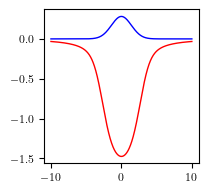

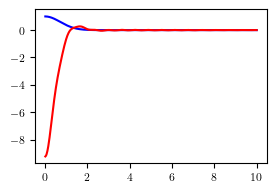

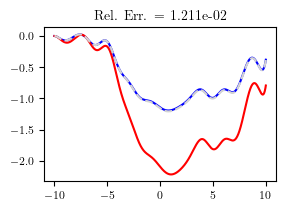

In [ ]:
# Define analytical spectral distribution lambda
density = lambda x: 1/(2*np.sqrt(np.pi))*np.exp(-x**2/4)
atoms = np.array([])
atom_wts = np.array([])
quad_pts, quad_wts = trap_quad(-10, 10, int(1e3))
lmbda = Distribution(density, atoms, atom_wts, quad_pts, quad_wts)

# Define noisy input trajectory x(t)
T0 = -10
T1 = 10
t = np.linspace(T0, T1, 1000)
dt = t[1] - t[0]

n_interp = 20
np.random.seed(15)
interp_xs = np.cumsum(np.insert(np.random.randn(n_interp), 0, 0))/np.sqrt(n_interp)
interp_ts = np.linspace(T0, T1, n_interp+1)
cs = scipy.interpolate.make_interp_spline(interp_ts, interp_xs, k=5)
x = cs(t)

# Define Volterra equation kernel and coefficients
K = complex_exp_kernel(lmbda, t)
K = K[t >= 0]
c0 = 1j
c1 = 0

# Compute output trajectory y(t) and corrupt it with noise
xdot = np.gradient(x, dt)
y = c1*xdot - 1j*c0*x + conv_trap(K, x, t)
ydot = np.gradient(y, dt)

# Use the spectral inversion map B to compute the inverse spectra mu and mu_hat from lambda and lambda_hat
#mu, zeta0, zeta1 = B_real(lmbda, c0, c1)

# Compute the analytical inverse kernel J corresponding to K, and use it to reconstruct x
#J_spectral = exp_kernel(mu, t)

#def mu_density(s):
#    exp2 = np.exp(-s**2/2)
#    exp4 = np.exp(-s**2/4)
#    erfi2 = scipy.special.erfi(s/2)**2
#    return -np.pi**2/16 * exp2*erfi2 + 8/np.sqrt(np.pi)*exp4 + 4*exp2 / (1 + np.pi**2/16*exp2*erfi2 + np.sqrt(np.pi)*exp4 + np.pi/4*exp2)

def mu_density(s):
    dens = 1/(2*np.sqrt(np.pi))*np.exp(-s**2/4) + 1/np.pi
    return dens/(dens**2 + 1/np.pi**2*scipy.special.dawsn(s/2)**2) - np.pi
mu_analytic = Distribution(mu_density, quad_pts=quad_pts, quad_wts=quad_wts)
J_analytic = complex_exp_kernel(mu_analytic, t[t >= 0])

zeta0 = 1j*np.pi**2
zeta1 = 0
x_analytic = (1/math.pi**2) * (zeta1*ydot - 1j*zeta0*y + conv_trap(J_analytic, y, t))

#rel_err_J = np.linalg.norm(J_spectral - J_analytic) / np.linalg.norm(J_analytic)
rel_err_x = np.linalg.norm(x_analytic - x) / np.linalg.norm(x)

fig, ax = plt.subplots(figsize=(2, 2))
plot_real_distribution(ax, lmbda, color="blue")
plot_real_distribution(ax, mu_analytic, color="red")
plt.savefig(f"../figures/main_pd_complex_distribution_inversion.pdf", bbox_inches='tight', pad_inches=0.08)
plt.show()

fig, ax = plt.subplots(figsize=(3, 2))
ax.plot(t[t >= 0], K, color="blue")
ax.plot(t[t >= 0], J_analytic, color="red")
plt.savefig(f"../figures/main_pd_complex_kernel_inversion.pdf", bbox_inches='tight', pad_inches=0.08)
plt.show()

fig, ax = plt.subplots(figsize=(3, 2))
ax.plot(t, x, color="blue", zorder=1)
ax.plot(t, y, color="red")
ax.plot(t, x_analytic, linestyle='--', color="lightgray")
ax.set_title(f"Rel. Err. = {rel_err_x:.3e}", size=10)
plt.savefig(f"../figures/main_pd_complex_data_inversion.pdf", bbox_inches='tight', pad_inches=0.08)
plt.show()

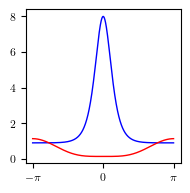

/Users/georgestepaniants/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/georgestepaniants/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


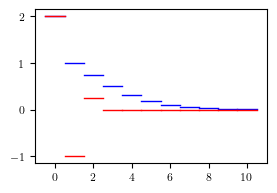

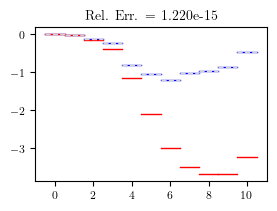

In [46]:
# Define analytical spectral distribution lambda
a = 1/2
density = lambda theta: np.real(2/(1 - a*np.exp(1j*theta))**2)
atoms = np.array([])
atom_wts = np.array([])
quad_pts, quad_wts = fourier_quad(-np.pi, np.pi, int(1e3))
lmbda = Distribution(density, atoms, atom_wts, quad_pts, quad_wts, periodic_domain=(-np.pi, np.pi))

T = int(11)
t = np.arange(0, T)

n_interp = 20
np.random.seed(15)
interp_xs = np.cumsum(np.insert(np.random.randn(n_interp), 0, 0))/np.sqrt(n_interp)
interp_ts = np.linspace(0, T, n_interp+1)
cs = scipy.interpolate.make_interp_spline(interp_ts, interp_xs, k=5)
x = cs(t)

# Define Volterra equation kernel and coefficients
K = complex_discrete_kernel(lmbda, t)
c1 = -1

# Compute output trajectory y(t) and corrupt it with noise
y = c1*x + conv_fourier(K, x, t)

mu_density = lambda theta: np.real((1 - a*np.exp(1j*theta))**2)/2
mu_analytic = Distribution(mu_density, quad_pts=quad_pts, quad_wts=quad_wts, periodic_domain=(-np.pi, np.pi))
J_analytic = 4*complex_discrete_kernel(mu_analytic, t)

zeta1 = -1
x_analytic = zeta1*y + conv_fourier(J_analytic, y, t)

#rel_err_J = np.linalg.norm(J_spectral - J_analytic) / np.linalg.norm(J_analytic)
rel_err_x = np.linalg.norm(x_analytic - x) / np.linalg.norm(x)

fig, ax = plt.subplots(figsize=(2, 2))
plot_real_distribution(ax, lmbda, color="blue")
plot_real_distribution(ax, mu_analytic, color="red")
ax.set_xticks(ticks=[-np.pi, 0, np.pi], labels=["$-\pi$", 0, "$\pi$"])
plt.savefig(f"../figures/main_dpd_distribution_inversion.pdf", bbox_inches='tight', pad_inches=0.08)
plt.show()

fig, ax = plt.subplots(figsize=(3, 2))
plot_discrete(ax, t, K, color="blue")
plot_discrete(ax, t, J_analytic, color="red")
ax.set_xticks(ticks=np.arange(0, T, 2))
plt.savefig(f"../figures/main_dpd_kernel_inversion.pdf", bbox_inches='tight', pad_inches=0.08)
plt.show()

fig, ax = plt.subplots(figsize=(3, 2))
plot_discrete(ax, t, x, color="blue")
plot_discrete(ax, t, y, color="red")
plot_discrete(ax, t, x_analytic, linestyle='--', color="lightgray")
ax.set_title(f"Rel. Err. = {rel_err_x:.3e}", size=10)
ax.set_xticks(ticks=np.arange(0, T, 2))
plt.savefig(f"../figures/main_dpd_data_inversion.pdf", bbox_inches='tight', pad_inches=0.08)
plt.show()